In [412]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})
import numpy as np

<Figure size 432x288 with 0 Axes>

In [413]:
# squared distance
def compute_distance_squared(x1, x2):
    """
    computes |\vec{x1} - \vec{x2}^T|^2
    """
    # return x1**2 + np.transpose(x2**2) - 2.0 * np.dot(x1, np.transpose(x2))
    return np.square(x1 - x2.T)

In [414]:
def squared_exponential_kernel(x1, x2, sigma_f, l):
    r_squared = compute_distance_squared(x1, x2)
    return sigma_f**2 * np.exp(-0.5 * r_squared / l**2)

In [415]:
x = np.linspace(0, 10, 100)[:,np.newaxis]

In [416]:
X = compute_distance_squared(x,x)

In [417]:
squared_exponential_kernel(x,x,1,0.5).shape

(100, 100)

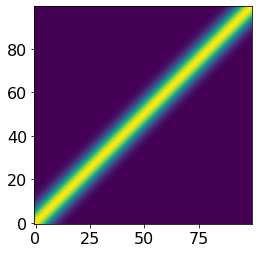

In [418]:
plt.imshow(squared_exponential_kernel(x,x,1,0.5), origin='lower')

In [419]:
def compute_covariance(x1, x2, kernel_fn, sigma_n=0., sigma_f=1., ell=1.):
    K = kernel_fn(x1, x2, sigma_f, ell)
    if sigma_n != 0.:
        K += sigma_n**2*np.eye(K.shape[0])
    return K

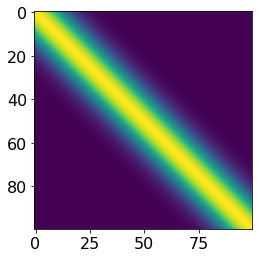

In [420]:
plt.imshow(compute_covariance(x, x, squared_exponential_kernel))

In [421]:
def GPR(Xtest, Xtrain, ytrain, kernel_fn=squared_exponential_kernel, sigma_n=0., sigma_f=1., ell=1.):
    """
    Compute mean and covariance of test data conditioned
    on the training data.
    Algorithm 2.1 in R&W 2006
    """
    K = compute_covariance(Xtrain, Xtrain, kernel_fn, sigma_n=sigma_n, sigma_f=sigma_f, ell=ell)
    L = np.linalg.cholesky(K + sigma_n*np.eye(K.shape[0]))
    # alpha = L.L' \ (L.L \ ytrain)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, ytrain))
    
    k_s = compute_covariance(Xtrain, Xtest, kernel_fn, sigma_n=0., sigma_f=sigma_f, ell=ell)
    # mean prediction
    
    
    f_star = np.dot(k_s.T, alpha)
    # covariance matrix prediction
    # v = L.L \ k_s
    v = np.linalg.solve(L, k_s)
    k_ss = compute_covariance(Xtest, Xtest, kernel_fn, sigma_n=0., sigma_f=sigma_f, ell=ell)
    # var_fstar = k_ss - np.dot(v.T, v)
    var_fstar = k_ss - v.T @ v # same as above

    # again because we need a positive semi-definite covariance matrix we add a small value to the diagonal.
    var_fstar_stablised = var_fstar + 1e-9*np.eye(var_fstar.shape[0])
    return np.random.multivariate_normal(f_star[:,0], var_fstar_stablised), f_star, var_fstar_stablised

In [422]:
Xtrain = np.random.uniform(1, 10, 10)[:,np.newaxis]
ytrain = np.sin(Xtrain)

Xtest = np.arange(-2, 12, 0.1)[:,np.newaxis]
ytest = np.sin(Xtest)


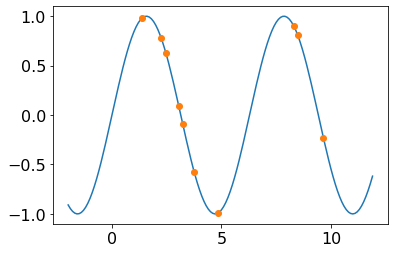

In [423]:
plt.plot(Xtest, ytest, '-')
plt.plot(Xtrain, ytrain, 'o')

In [424]:
gpr_dist, f_star, var_fstar = GPR(Xtest, Xtrain, ytrain, kernel_fn=squared_exponential_kernel, sigma_n=1e-3, sigma_f=1., ell=1.)

In [425]:
var_fstar.shape

(140, 140)

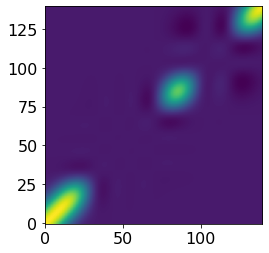

In [426]:
plt.imshow(var_fstar, origin='lower')

In [427]:
samples = np.random.multivariate_normal(f_star[:,0], var_fstar, 50)

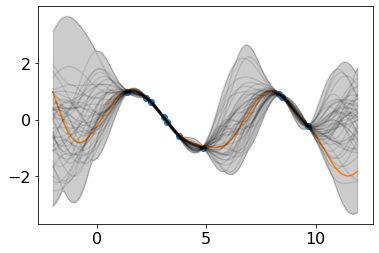

In [428]:
plt.plot(Xtrain, ytrain, 'o')
plt.plot(Xtest, gpr_dist)
plt.plot(Xtest, samples.T, c='k', alpha=0.1);
plt.fill_between(Xtest[:,0], y1=samples.min(0), y2=samples.max(0), color='k', alpha=0.2);

# Heteroscedastic GPR

https://blog.ivanukhov.com/2020/06/22/gaussian-process.html

(blog was based on https://github.com/mattiasvillani/AdvBayesLearnCourse/blob/master/Labs/Lab1.pdf)

data: http://matt-wand.utsacademics.info/webspr/data.html

Light detection and ranging (LIDAR): Section 2.7

http://matt-wand.utsacademics.info/webspr/lidar.html

http://matt-wand.utsacademics.info/webspr/lidar.txt

LIDAR data
Description
The lidar data frame has 221 observations from a light detection and ranging (LIDAR) experiment.

Format
This data frame contains the following columns:

range: distance travelled before the light is reflected back to its source.

logratio: logarithm of the ratio of received light from two laser sources.

Source:

Sigrist, M. (Ed.) (1994). Air Monitoring by Spectroscopic Techniques (Chemical Analysis Series, vol. 197). New York: Wiley.

References
Ruppert, D., Wand, M.P. and Carroll, R.J. (2003)
Semiparametric Regression Cambridge University Press.
http://stat.tamu.edu/~carroll/semiregbook/


In [429]:
import pandas as pd
import numpy as np

In [430]:
# df = pd.read_csv("http://matt-wand.utsacademics.info/webspr/lidar.txt", sep='\s+')

In [431]:
# df.to_csv("/Users/sebastian.khan/Downloads/lidar.csv", index=False)

In [432]:
df = pd.read_csv("/Users/sebastian.khan/Downloads/lidar.csv")

In [433]:
df['ratio'] = df.apply(lambda x: np.exp(x['logratio']), 1)

<AxesSubplot:xlabel='range', ylabel='ratio'>

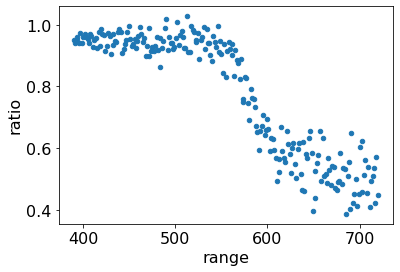

In [434]:
df.plot(kind='scatter', x='range', y='ratio')
# df.plot(kind='scatter', x='range', y='logratio')

In [435]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = df['range'].values[:,np.newaxis]
X = scaler.fit_transform(X)
y = df['ratio'].values[:,np.newaxis]

In [436]:
# Xtest = np.arange(400, 720, 1)[:,np.newaxis]
Xtest = np.arange(0, 1, 0.01)[:,np.newaxis]

In [557]:
gpr_dist, f_star, var_fstar = GPR(
    Xtest,
    X,
    y,
    kernel_fn=squared_exponential_kernel,
    sigma_n=1e-1,
    sigma_f=0.5,
    ell=0.2
)

In [558]:
samples = np.random.multivariate_normal(f_star[:,0], var_fstar, 50)

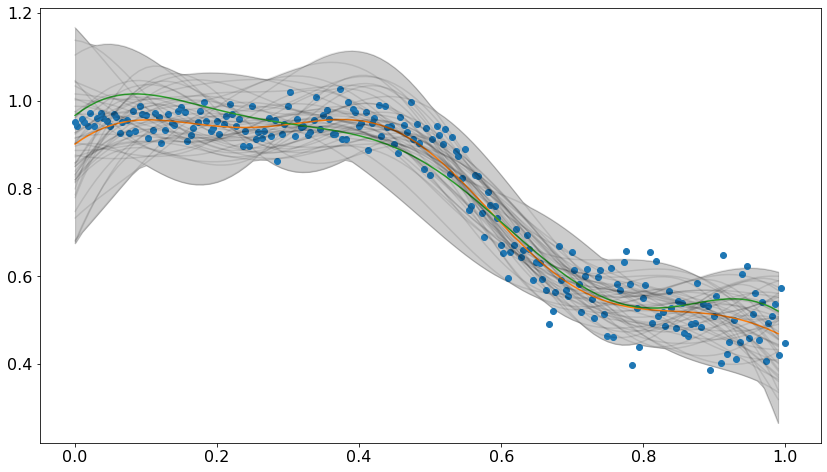

In [559]:
plt.figure(figsize=(14, 8))
plt.plot(X, y, 'o')
plt.plot(Xtest, f_star[:,0])
plt.plot(Xtest, gpr_dist)
plt.plot(Xtest, samples.T, c='k', alpha=0.1);
plt.fill_between(Xtest[:,0], y1=samples.min(0), y2=samples.max(0), color='k', alpha=0.2);

In [528]:
def GPR_heteroskedastic(Xtest, Xtrain, ytrain, alpha_noise, beta_noise, kernel_fn=squared_exponential_kernel, sigma_n=0., sigma_f=1., ell=1.):
    """
    Compute mean and covariance of test data conditioned
    on the training data.
    Algorithm 2.1 in R&W 2006
    """
    K = compute_covariance(Xtrain, Xtrain, kernel_fn, sigma_n=sigma_n, sigma_f=sigma_f, ell=ell)
    L = np.linalg.cholesky(K + sigma_n*np.eye(K.shape[0]))
    # alpha = L.L' \ (L.L \ ytrain)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, ytrain))
    
    k_s = compute_covariance(Xtrain, Xtest, kernel_fn, sigma_n=0., sigma_f=sigma_f, ell=ell)
    # mean prediction
    
    
    f_star = np.dot(k_s.T, alpha)
    # covariance matrix prediction
    # v = L.L \ k_s
    v = np.linalg.solve(L, k_s)
    k_ss = compute_covariance(Xtest, Xtest, kernel_fn, sigma_n=0., sigma_f=sigma_f, ell=ell)
    # var_fstar = k_ss - np.dot(v.T, v)
    var_fstar = k_ss - v.T @ v # same as above
    
    ### heteroskedastic bit
    # sigma_test == ln(sigma**2)
    sigma_test = alpha_noise + Xtest[:,0] * beta_noise
    sigma_test = np.exp(sigma_test)
    # sigma_test = sigma_test**2
    # print(sigma_test)
    # plt.plot(Xtest[:,0], sigma_test)
    sigma_test_matrix = np.eye(k_ss.shape[0]) * sigma_test
    var_fstar = var_fstar + sigma_test_matrix
    ###

    # again because we need a positive semi-definite covariance matrix we add a small value to the diagonal.
    var_fstar_stablised = var_fstar #+ 1e-9*np.eye(var_fstar.shape[0])
    return np.random.multivariate_normal(f_star[:,0], var_fstar_stablised), f_star, var_fstar_stablised

In [563]:
gpr_dist, f_star, var_fstar = GPR_heteroskedastic(
    Xtest,
    X,
    y,
    alpha_noise=-7.5,
    beta_noise=3.5,
    kernel_fn=squared_exponential_kernel,
    sigma_n=1e-3,
    sigma_f=0.5,
    ell=0.2
)

In [564]:
samples = np.random.multivariate_normal(f_star[:,0], var_fstar, 100)

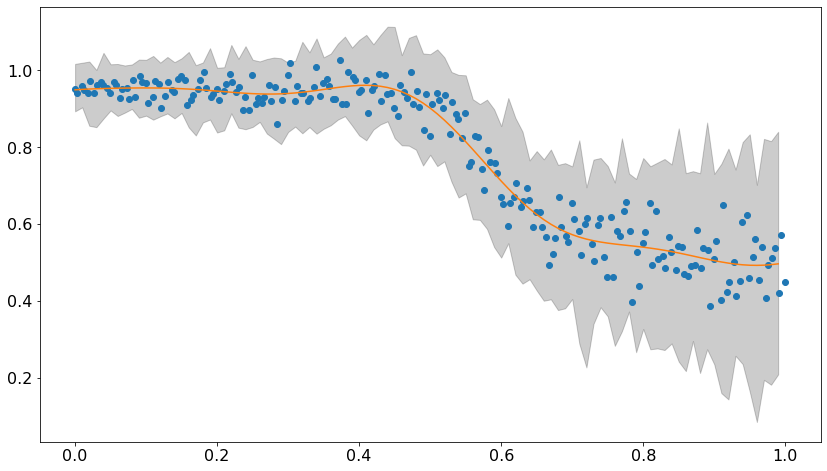

In [566]:
plt.figure(figsize=(14, 8))
plt.plot(X, y, 'o')
plt.plot(Xtest, f_star[:,0])
# plt.plot(Xtest, gpr_dist)
# plt.plot(Xtest, samples.T, c='k', alpha=0.1);
plt.fill_between(Xtest[:,0], y1=samples.min(0), y2=samples.max(0), color='k', alpha=0.2);

In [ ]:
# why are the samples so choppy now?

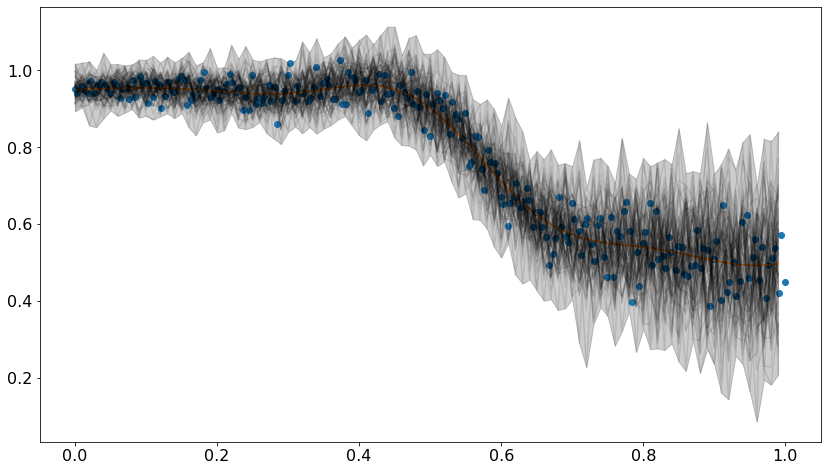

In [567]:
plt.figure(figsize=(14, 8))
plt.plot(X, y, 'o')
plt.plot(Xtest, f_star[:,0])
# plt.plot(Xtest, gpr_dist)
plt.plot(Xtest, samples.T, c='k', alpha=0.1);
plt.fill_between(Xtest[:,0], y1=samples.min(0), y2=samples.max(0), color='k', alpha=0.2);